https://github.com/NikolayOskolkov/UMAPDataIntegration

In [27]:
# код с PCA мой - ПДД, идея этого же чувака, 
# где он рассуждает как tSNE применять - https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868

import os
import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np
import pandas as pd

from scipy.stats import norm
from sklearn.decomposition import PCA

def get_variance_by_chance(dataset, n_replics, n_components):
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")
        random_data = dataset.copy().apply(np.random.permutation, axis=0)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
    return variance_explained_by_chance

def get_pc_variance(dataset, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    return pca.explained_variance_ratio_

def plot_mean_and_CI(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    # plot the shaded range of the confidence intervals
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    # plot the mean on top
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label='real', lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_CI(ax, variance_by_chance, label='chance', color_mean='red', color_shading='red')

def calc_permutat_pval(real_values, permut_values, eps=None):
    eps = eps or (1/(permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f'PCA {dataset_name}', size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ration", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], 5))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, 5), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], 5))
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, 5), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=100, color="red", linestyles="dashed", lw=3)
    
    
def pca_analysis(ax1, ax2, dataset, title ,  transpose, n_replics = 1000, n_components = 100):

    if transpose:
        dataset = dataset.transpose()
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, title)
    plot_pval_plot(ax2, p_values, title)

In [28]:
import numpy as np
import pandas as pd

Еще два датасета с данным синг-селл секвенирования. (single cell RNAseq and protein level data sets from 8617 blood mononuclear cells (CBMCs) )a dataset of 8,617 cord blood mononuclear cells (CBMCs), produced with CITE-seq, where we simultaneously measure the single cell transcriptomes alongside the expression of 11 surface proteins, whose levels are quantified with DNA-barcoded antibodies. Источник - вот https://pubmed.ncbi.nlm.nih.gov/28759029/

Тут можно посмотреть, по какому принципу покрашены клетки крови
https://pubmed.ncbi.nlm.nih.gov/28759029/#&gid=article-figures&pid=figure-3-uid-2

По сути - просто по своему типу. 

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

scRNAseq = pd.read_csv('scRNAseq_CITEseq.txt',sep='\t')
scProteomics = pd.read_csv('scProteomics_CITEseq.txt',sep='\t')

X_scRNAseq = scRNAseq.iloc[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.iloc[:,scRNAseq.shape[1]-1]
X_scProteomics = scProteomics.iloc[:,0:(scProteomics.shape[1]-1)]
Y_scProteomics = scProteomics.iloc[:,scProteomics.shape[1]-1]

X_scRNAseq = np.log(X_scRNAseq + 1)
X_scProteomics = np.log(X_scProteomics + 1)

Выбираем число компонент

0 iter



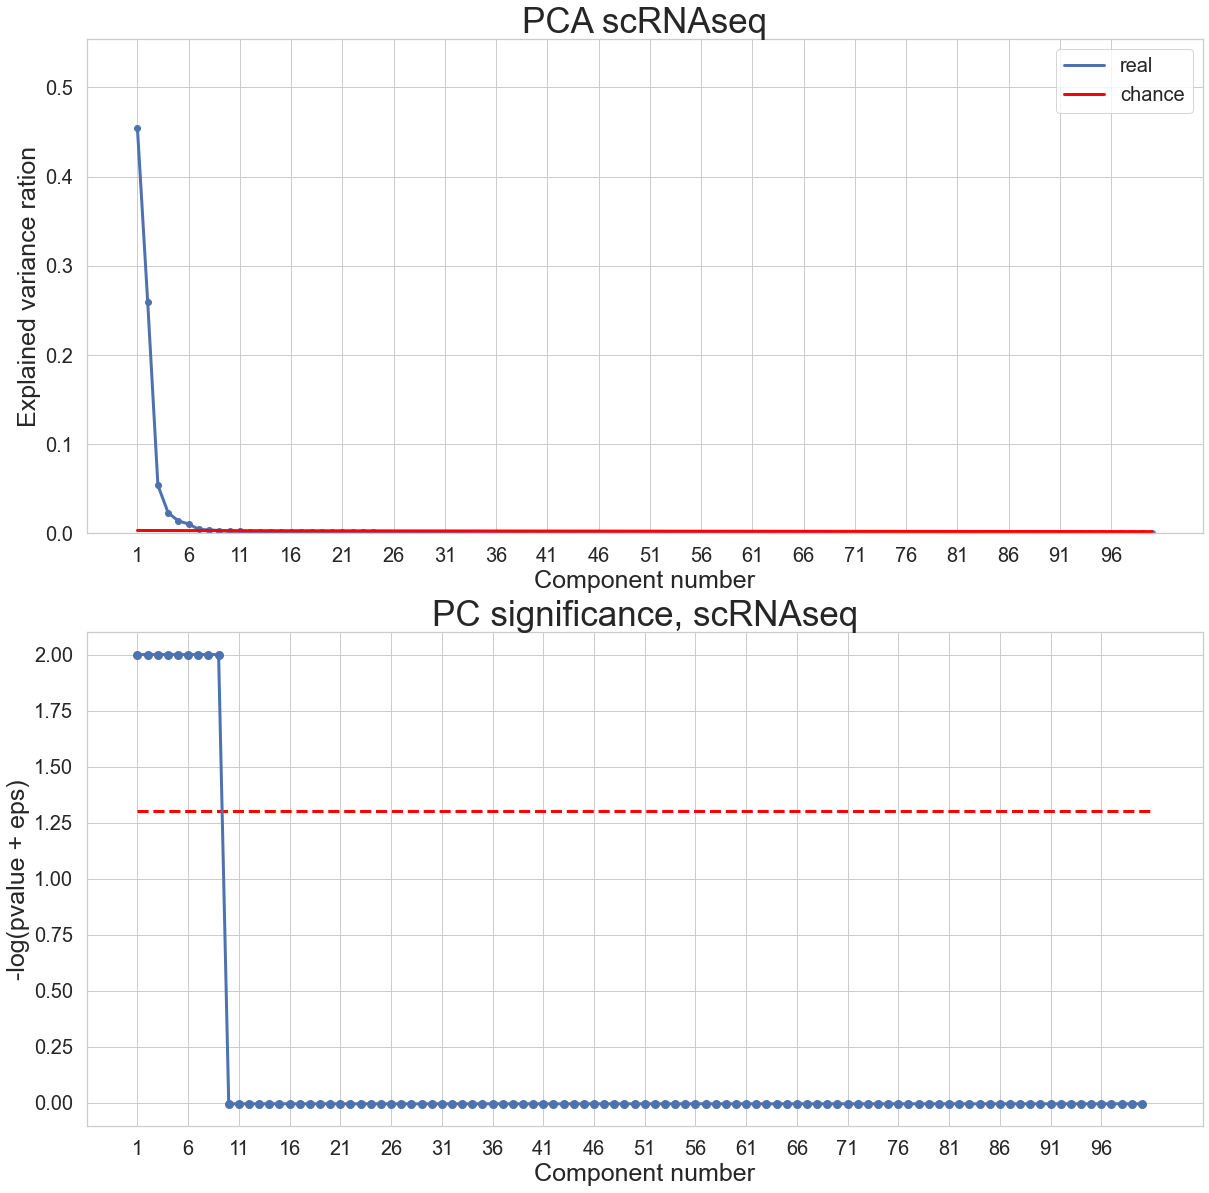

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, X_scRNAseq, "scRNAseq", transpose=True, n_replics=10)

Let us display the UMAP embeddings of individual OMICs data sets. We will start with the scRNAseq dataset. As an optimal number of nearest neighbors we will choose sqrt(N) = sqrt(8617) = 93.

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False,
     init=array([[45.31235894,  0.07477159],
       [46.53271754,  1.71486063],
       [46.8638235 ,  0.98846408],
       ...,
       [ 1.11426643, -1.86512337],
       [ 4.54796886, -0.69171758],
       [ 2.61794017, -0.97065852]]),
     learning_rate=1.0, local_connectivity=1.0, low_memory=False,
     metric='euclidean', metric_kwds=None, min_dist=1, n_components=2,
     n_epochs=1000, n_neighbors=93, negative_sample_rate=5,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, unique=False, verbose=2)
Construct fuzzy simplicial set
Thu Jan 14 08:10:20 2021 Finding Nearest Neighbors
Thu Jan 14 08:10:20 2021 Building RP forest with 10 trees
Thu Jan 14 08:10:20 2

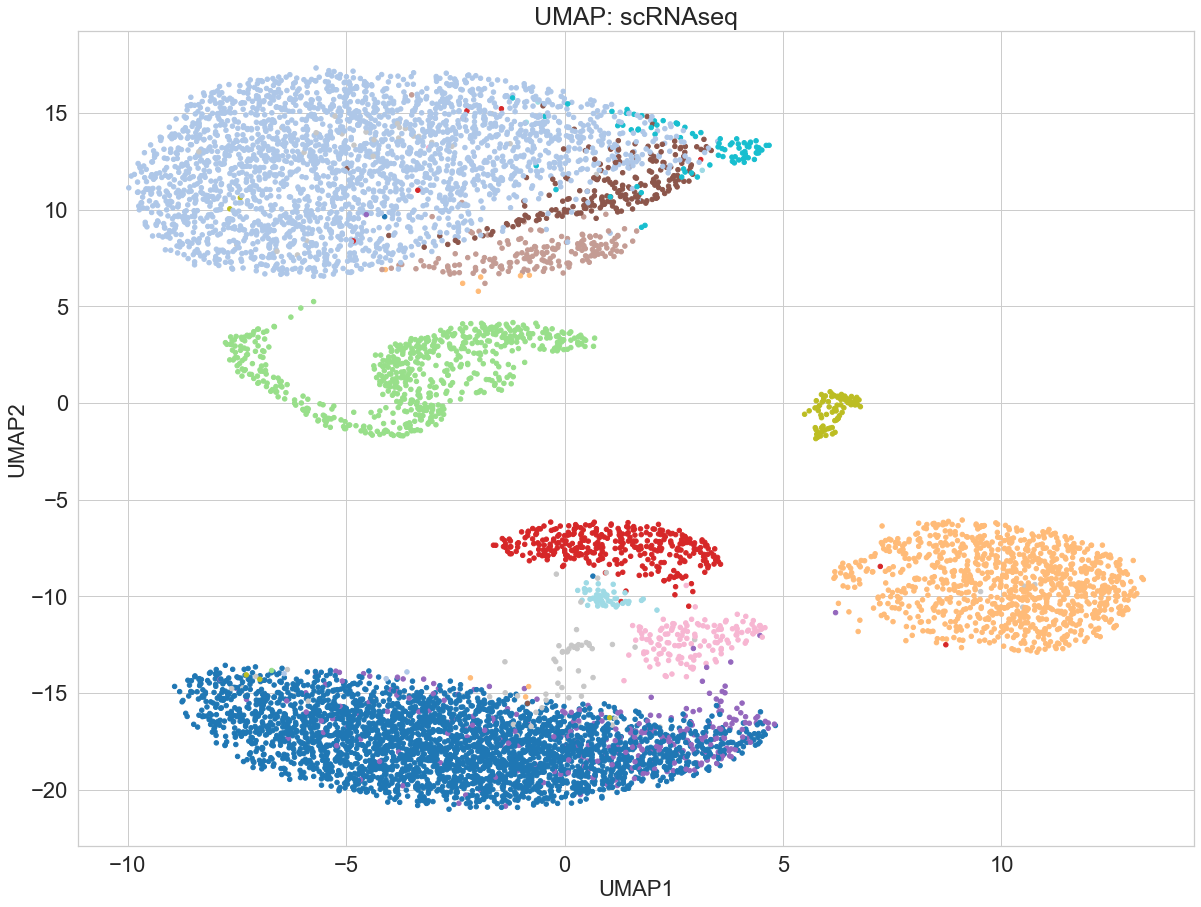

In [32]:
import warnings
warnings.filterwarnings("ignore")

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_reduced = PCA(n_components = 9).fit_transform(X_scRNAseq)
model = UMAP(n_components = 2, 
             min_dist = 1, 
             n_neighbors = 93,
             init = X_reduced[:, 0:2], 
             # много где, не только он, рекомендуют использовать для инициализации UMAP и tSNE первые две компоненты PCA
             n_epochs = 1000, 
             verbose = 2)
umap = model.fit_transform(X_reduced)

plt.figure(figsize = (20,15))
plt.scatter(umap[:, 0], umap[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 20)
plt.title('UMAP: scRNAseq', fontsize = 25); 
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.005s...
[t-SNE] Computed neighbors for 8617 samples in 0.628s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 0.389078
[t-SNE] Computed conditional probabilities in 0.282s
[t-SNE] Iteration 50: error = 76.5206299, gradient norm = 0.0031719 (50 iterations in 2.228s)
[t-SNE] Iteration 100: error = 76.0460510, gradient norm = 0.0009648 (50 iterations in 1.

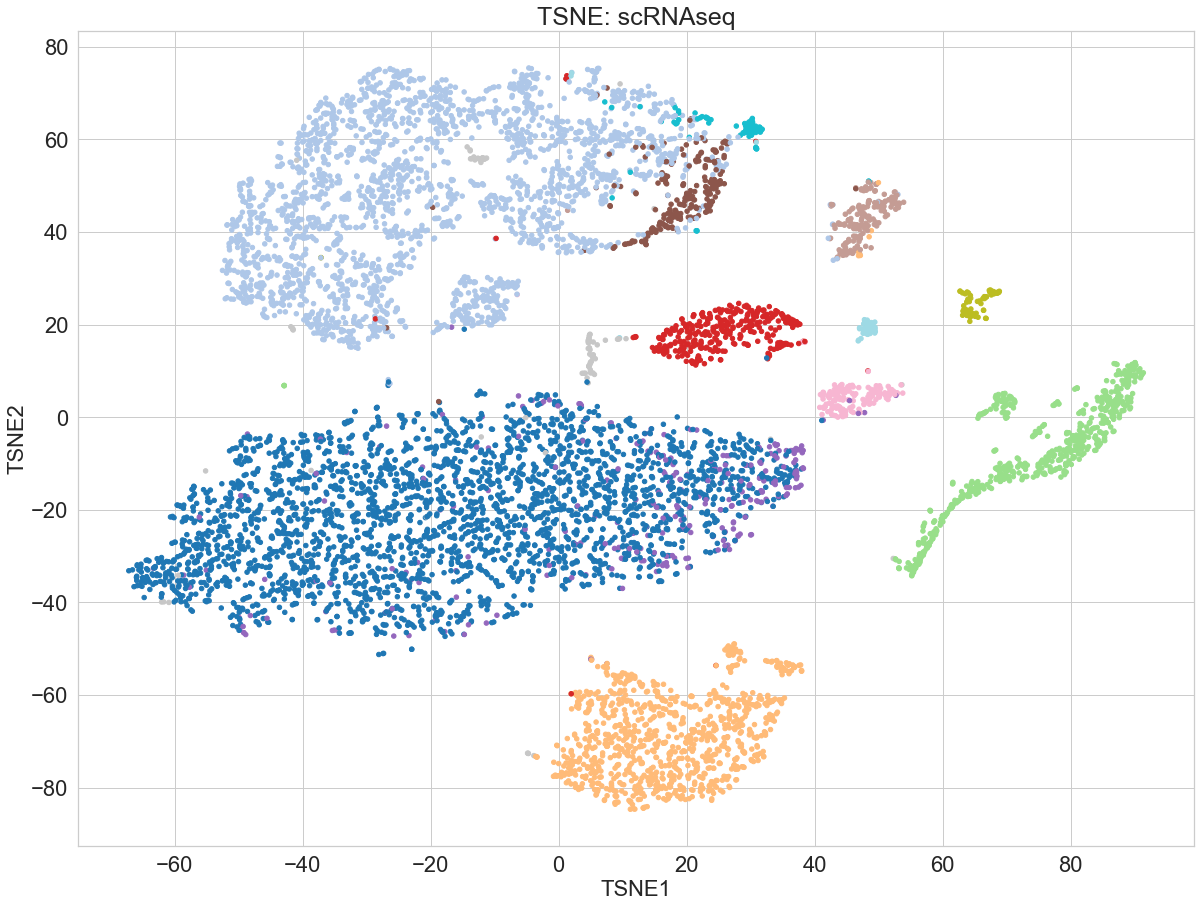

In [40]:
import warnings
warnings.filterwarnings("ignore")

import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_reduced = PCA(n_components = 9).fit_transform(X_scRNAseq)
model = sklearn.manifold.TSNE(n_components = 2, 
             init = X_reduced[:, 0:2], 
             # много где, не только он, рекомендуют использовать для инициализации UMAP и tSNE первые две компоненты PCA
             verbose = 2)
umap = model.fit_transform(X_reduced)

plt.figure(figsize = (20,15))
plt.scatter(umap[:, 0], umap[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 20)
plt.title('TSNE: scRNAseq', fontsize = 25); 
plt.xlabel("TSNE1", fontsize = 22); plt.ylabel("TSNE2", fontsize = 22)
plt.show()

Now let us display UMAP embeddings for the scProteomics dataset of the CITE-seq sequencing technology.

0 iter



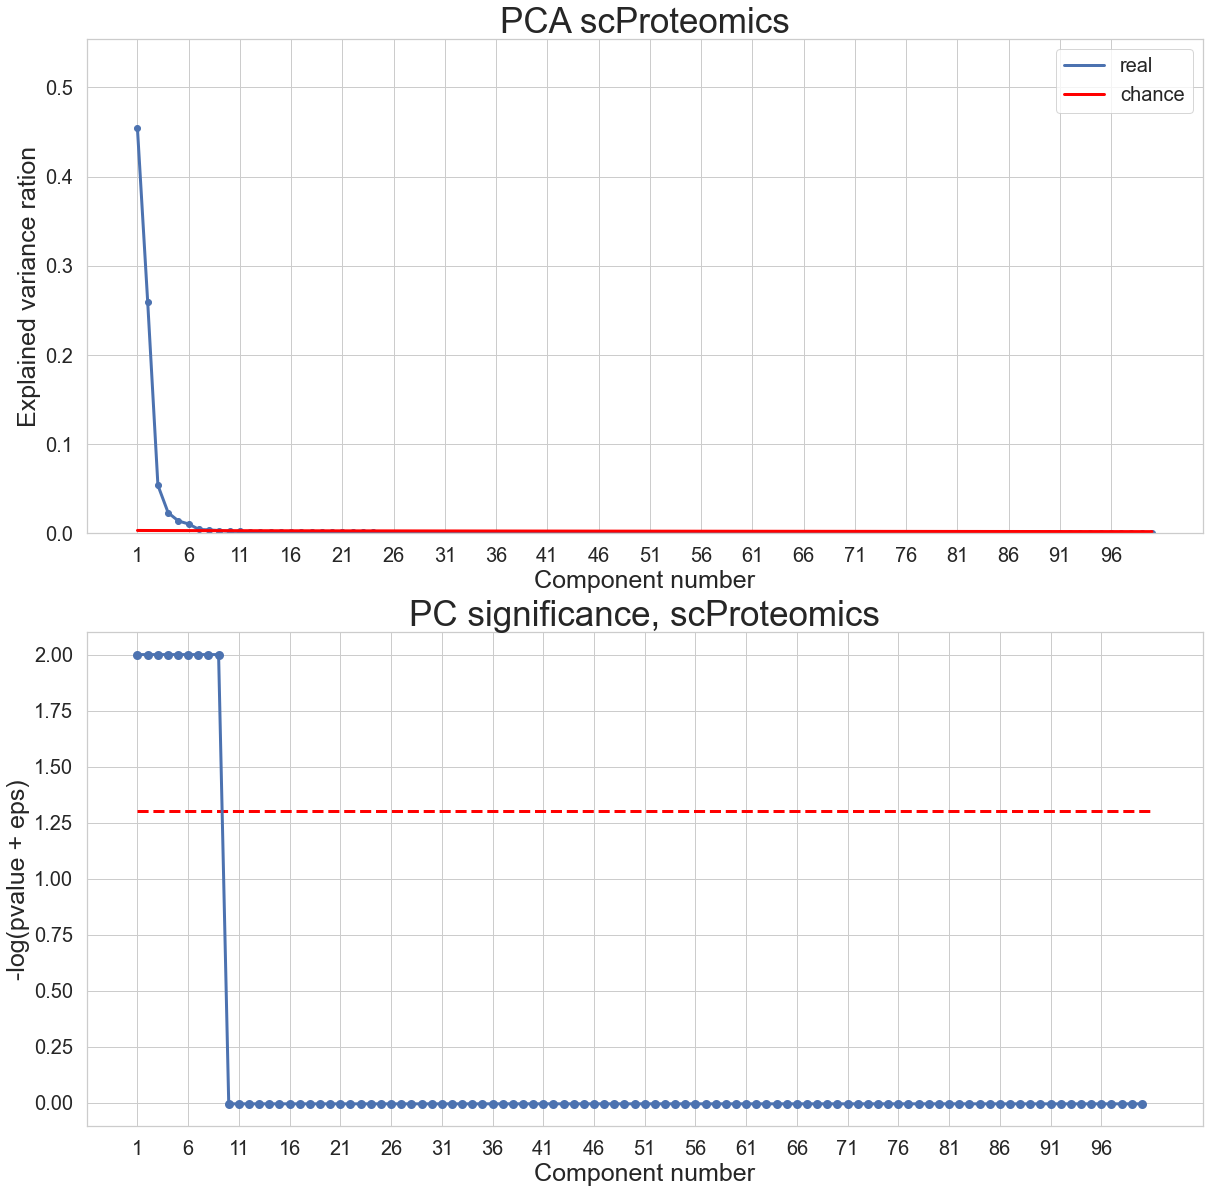

In [33]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, X_scRNAseq, "scProteomics", transpose=True, n_replics=10)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False,
     init=array([[-1.65366402, -0.2564025 ],
       [-1.7084814 ,  1.69115812],
       [-1.03060202, -0.13172222],
       ...,
       [-2.19859839, -5.16795233],
       [-2.10143214, -2.48594223],
       [-2.43134931, -3.33697131]]),
     learning_rate=1.0, local_connectivity=1.0, low_memory=False,
     metric='euclidean', metric_kwds=None, min_di...8, n_components=2,
     n_epochs=1000, n_neighbors=93, negative_sample_rate=5,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, unique=False, verbose=2)
Construct fuzzy simplicial set
Thu Jan 14 08:12:11 2021 Finding Nearest Neighbors
Thu Jan 14 08:12:11 2021 Building RP forest with 10 trees
Thu Jan 14 08:12:11 2

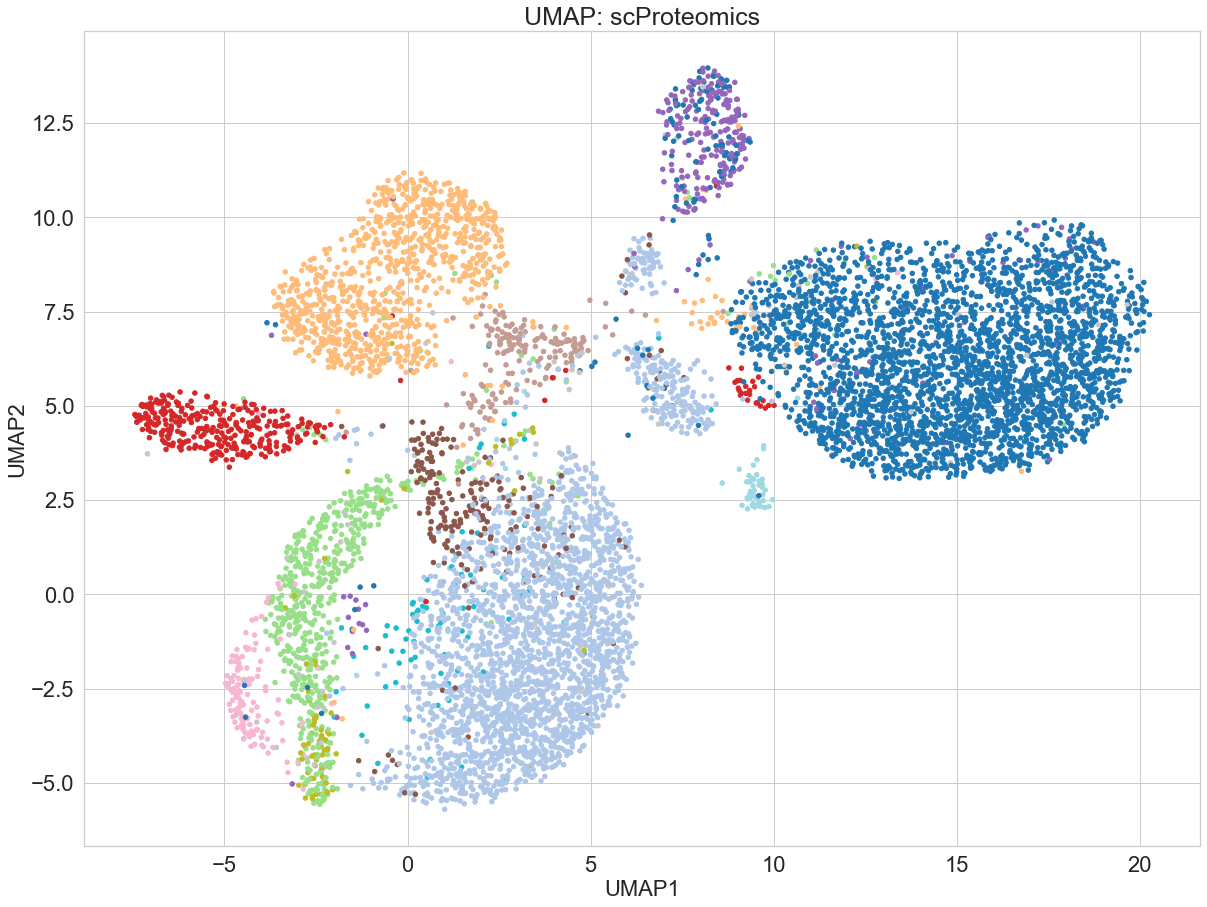

In [34]:
import warnings
warnings.filterwarnings("ignore")

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_reduced = PCA(n_components = 9).fit_transform(X_scProteomics)
model = UMAP(n_components = 2, min_dist = 0.8, n_neighbors = 93, init = X_reduced[:, 0:2], n_epochs = 1000, 
             verbose = 2)
umap = model.fit_transform(X_reduced)

plt.figure(figsize = (20,15))
plt.scatter(umap[:, 0], umap[:, 1], c = Y_scProteomics, cmap = 'tab20', s = 20)
plt.title('UMAP: scProteomics', fontsize = 25); 
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)
plt.show()

UMAP позволяет строить объединение двух эмбедингов, что часто круто для анализа данных, в том числе биологических. 
К тому же - можно отдельно построить UMAP для вещественных и категориальных переменных (расстояния для них использовать порой надо разные), а потом объединить

( UMAP allows for fast individual scOmics graph building and intersection wioth just a few lines of code, see the interesting discussion about mixing different data types here https://github.com/lmcinnes/umap/issues/58.

Here we will overlap graphs from single cell RNAseq and Proteomics data sets from the CITE-seq technology (https://en.wikipedia.org/wiki/CITE-Seq), and produce a consensus / integrative OMICs UMAP plot. The idea is to convert the two data types into graphs, i.e. non-parametric space where they forget their technological differences, and overlap the graphs. The resulting graph will be used for constructing the UMAP embeddings.)

In [20]:
import umap

X_reduced_scRNAseq = PCA(n_components = 9).fit_transform(X_scRNAseq)
X_reduced_scProteomics = PCA(n_components = 9).fit_transform(X_scProteomics)

fit1 = umap.UMAP(n_components = 2, min_dist = 1, n_neighbors = 93, n_epochs = 1000, 
                 init = X_reduced_scRNAseq[:, 0:2], verbose = 2).fit(X_reduced_scRNAseq)
fit2 = umap.UMAP(n_components = 2, min_dist = 0.8, n_neighbors = 93, n_epochs = 1000, 
                 init = X_reduced_scProteomics[:, 0:2], verbose = 2).fit(X_reduced_scProteomics)
intersection = umap.umap_. general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight = 0.45)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1.learning_rate, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                1000, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False,
     init=array([[45.31235894,  0.07477159],
       [46.53271754,  1.71486063],
       [46.8638235 ,  0.98846408],
       ...,
       [ 1.11426643, -1.86512337],
       [ 4.54796886, -0.69171758],
       [ 2.61794017, -0.97065852]]),
     learning_rate=1.0, local_connectivity=1.0, low_memory=False,
     metric='euclidean', metric_kwds=None, min_dist=1, n_components=2,
     n_epochs=1000, n_neighbors=93, negative_sample_rate=5,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, unique=False, verbose=2)
Construct fuzzy simplicial set
Thu Jan 14 07:53:07 2021 Finding Nearest Neighbors
Thu Jan 14 07:53:07 2021 Building RP forest with 10 trees
Thu Jan 14 07:53:07 2

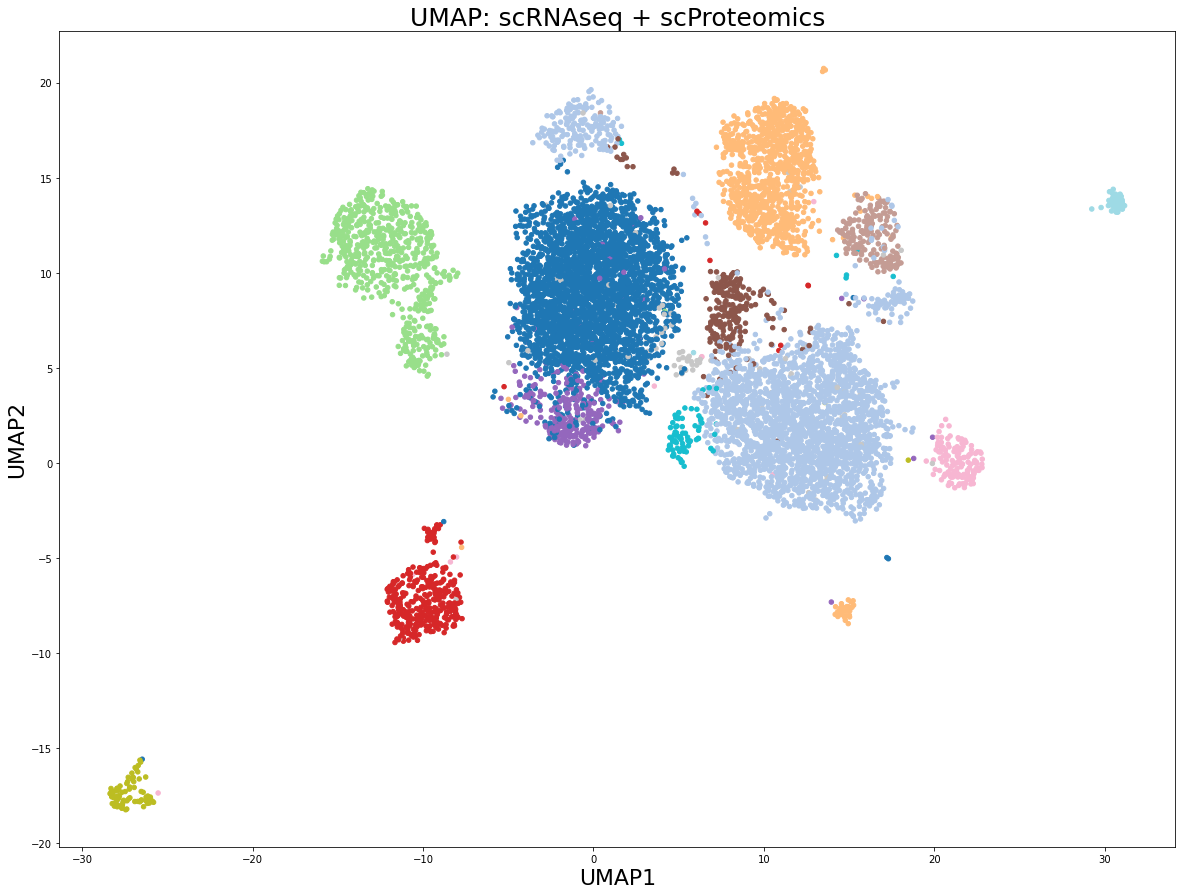

In [17]:
plt.figure(figsize = (20,15))
plt.scatter(embedding[:, 0], embedding[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 20)
plt.title('UMAP: scRNAseq + scProteomics', fontsize = 25); 
plt.xlabel("UMAP1", fontsize = 22); plt.ylabel("UMAP2", fontsize = 22)
plt.show()